In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from cdrift import evaluation
from cdrift.utils.helpers import readCSV_Lists, convertToTimedelta, importLog
import numpy as np
from datetime import datetime
from statistics import mean, harmonic_mean, stdev
from scipy.stats import iqr
from typing import List
import seaborn as sns
import re
import os
from pathlib import Path

LAG_WINDOW = 200
MIN_SUPPORT = 1 # Minimum support for latency calculation --> a parameter setting must have at least 3 instances where a true positive was detected before it can be deemed the "best parameter setting" for latency calculation

CSV_PATH = "algorithm_results.csv"
OUT_PATH = "Evaluation_Results"

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

## Preprocessing

In [2]:
df = readCSV_Lists(CSV_PATH)
df.copy()

,Algorithm,Log Source,Log,Window Size,SW Step Size,Min Adaptive Window,Max Adaptive Window,ADWIN Step Size,P-Value,Complete-Window Size,Detection-Window Size,Stable Period,MRID,Epsilon,Detected Changepoints,Actual Changepoints for Log,F1-Score,Average Lag,Duration,Duration (Seconds)
0,Zheng DBSCAN,Ostovar,Atomic_Frequency_output_Frequency_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,400.0,40.0,[1516.9802143446002],"[999, 1999]",NaN,NaN,0 days 00:00:04,4.000000
1,Zheng DBSCAN,Ostovar,Atomic_Frequency_output_Frequency_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,400.0,80.0,[1516.9802143446002],"[999, 1999]",NaN,NaN,0 days 00:00:04,4.000000
2,Zheng DBSCAN,Ostovar,Atomic_Frequency_output_Frequency_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,400.0,120.0,[1516.9802143446002],"[999, 1999]",NaN,NaN,0 days 00:00:04,4.000000
3,Zheng DBSCAN,Ostovar,Atomic_Frequency_output_Frequency_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,400.0,160.0,[1516.9802143446002],"[999, 1999]",NaN,NaN,0 days 00:00:04,4.000000
4,Zheng DBSCAN,Ostovar,Atomic_Frequency_output_Frequency_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,400.0,200.0,[1516.9802143446002],"[999, 1999]",NaN,NaN,0 days 00:00:04,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39708,LCDD,Ceravolo,sudden_trace_noise15_1000_sw,NaN,NaN,NaN,NaN,NaN,NaN,200.0,200.0,50.0,NaN,NaN,[448],[499],1.000000,51.0,0 days 00:00:00,0.024036
39709,LCDD,Ceravolo,sudden_trace_noise0_1000_cp,NaN,NaN,NaN,NaN,NaN,NaN,600.0,600.0,20.0,NaN,NaN,[],[499],NaN,NaN,0 days 00:00:00,0.023672
39710,LCDD,Ceravolo,sudden_trace_noise20_1000_IOR,NaN,NaN,NaN,NaN,NaN,NaN,100.0,100.0,100.0,NaN,NaN,[447],[499],1.000000,52.0,0 days 00:00:00,0.028069
39711,LCDD,Ostovar,Atomic_SerialRemoval_output_SerialRemoval,NaN,NaN,NaN,NaN,NaN,NaN,800.0,800.0,20.0,NaN,NaN,[923],"[999, 1999]",0.666667,76.0,0 days 00:00:00,0.142721


### Exclude Martjushev WC (In favor of LCDD)

In [3]:
df = df[df["Algorithm"] != "Martjushev ADWIN WC"]

### Rename approaches to shorter names

In [4]:
print(df["Algorithm"].unique())
shorter_names = {
    "Zheng DBSCAN": "RINV",
    "ProDrift": "ProDrift",
    "Bose J": "J-Measure",
    "Bose WC": "Window Count",
    "Earth Mover's Distance": "EMD",
    "Process Graph Metrics": "PGM",
    "Martjushev ADWIN J": "ADWIN J",
    "Martjushev ADWIN WC": "ADWIN WC",
    "LCDD": "LCDD"
}
df["Algorithm"] = df["Algorithm"].map(shorter_names)
df["Algorithm"].unique()

['Zheng DBSCAN' 'ProDrift' 'Bose J' 'Bose WC' "Earth Mover's Distance"
 'Martjushev ADWIN J' 'Process Graph Metrics' 'LCDD']


array(['RINV', 'ProDrift', 'J-Measure', 'Window Count', 'EMD', 'ADWIN J',
       'PGM', 'LCDD'], dtype=object)

In [5]:
# Order in which to plot the approaches, to stay consistent
ALPHA_SORT_NAMES = sorted(list(df["Algorithm"].unique()))
ALPHA_SORT_NAMES

['ADWIN J',
 'EMD',
 'J-Measure',
 'LCDD',
 'PGM',
 'ProDrift',
 'RINV',
 'Window Count']

### Only use Atomic Logs

In [6]:
atomic_logs = {
    log
    for index, (source, log) in df[["Log Source", "Log"]].iterrows()
    if (source.lower() == "ostovar" and log.lower().startswith("atomic")) # Only use atomic logs from ostovar
    or (log.lower().startswith("bose")) # Use bose log
    or (source.lower() == "ceravolo" and set(log.lower().split("_")[-1]) != {'i', 'o', 'r'}) # Exclude all composite (IOR, ROI, etc.) logs from ceravolo
}

df = df[df["Log"].isin(atomic_logs)]

### Calculate Log Lengths for Scalability

In [7]:
_groupkeys = list(df.groupby(["Log Source", "Log"]).groups.keys())
_logpaths = [Path("EvaluationLogs", source, f"{log}.xes.gz") for source, log in _groupkeys]

loglengths = dict()
loglengths_events = dict()

for logpath in _logpaths:
    log = importLog(logpath.as_posix(), verbose=False)
    loglengths[logpath] = len(log)
    loglengths_events[logpath] = len([evt for case in log for evt in case])

In [8]:
print(f"Number of Logs: {len(loglengths.keys())}")
print(f"Number of Cases: {sum(loglengths.values())}")
print(f"Number of Events: {sum(loglengths_events.values())}")

Number of Logs: 90
Number of Cases: 172961
Number of Events: 4508965


##### Number of Drifts

In [9]:
num_drifts = sum(
    len(group.iloc[0]["Actual Changepoints for Log"])
    for name, group in df.groupby(["Log Source", "Log"])
)
print("Total number of drifts:", num_drifts)

Total number of drifts: 132


### Check for Duplicate Rows (Sanity Check)

In [10]:
def split_by_name(df):
    return [
        (alg, df[df["Algorithm"] == alg].copy())
        for alg in df["Algorithm"].unique()
    ]

dfs = split_by_name(df)

if not pd.read_csv(CSV_PATH).duplicated().any():
    print("No duplicate rows in the Dataframe! :)")
else:
    for name, d in split_by_name(pd.read_csv(CSV_PATH)):
        print(f"{name} contains duplicate rows: {d.duplicated().any()}")

df

No duplicate rows in the Dataframe! :)


,Algorithm,Log Source,Log,Window Size,SW Step Size,Min Adaptive Window,Max Adaptive Window,ADWIN Step Size,P-Value,Complete-Window Size,Detection-Window Size,Stable Period,MRID,Epsilon,Detected Changepoints,Actual Changepoints for Log,F1-Score,Average Lag,Duration,Duration (Seconds)
0,RINV,Ostovar,Atomic_Frequency_output_Frequency_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,400.0,40.0,[1516.9802143446002],"[999, 1999]",NaN,NaN,0 days 00:00:04,4.000000
1,RINV,Ostovar,Atomic_Frequency_output_Frequency_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,400.0,80.0,[1516.9802143446002],"[999, 1999]",NaN,NaN,0 days 00:00:04,4.000000
2,RINV,Ostovar,Atomic_Frequency_output_Frequency_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,400.0,120.0,[1516.9802143446002],"[999, 1999]",NaN,NaN,0 days 00:00:04,4.000000
3,RINV,Ostovar,Atomic_Frequency_output_Frequency_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,400.0,160.0,[1516.9802143446002],"[999, 1999]",NaN,NaN,0 days 00:00:04,4.000000
4,RINV,Ostovar,Atomic_Frequency_output_Frequency_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,400.0,200.0,[1516.9802143446002],"[999, 1999]",NaN,NaN,0 days 00:00:04,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39704,LCDD,Ostovar,Atomic_ParallelMove_output_ParallelMove_2,NaN,NaN,NaN,NaN,NaN,NaN,800.0,800.0,200.0,NaN,NaN,"[800, 1601, 2402]","[999, 1999]",0.400000,199.0,0 days 00:00:00,0.217096
39705,LCDD,Ostovar,Atomic_SerialMove_output_SerialMove_5,NaN,NaN,NaN,NaN,NaN,NaN,400.0,400.0,20.0,NaN,NaN,"[400, 800, 1201, 1606, 2007, 2408, 2808]","[999, 1999]",0.444444,103.5,0 days 00:00:00,0.203214
39708,LCDD,Ceravolo,sudden_trace_noise15_1000_sw,NaN,NaN,NaN,NaN,NaN,NaN,200.0,200.0,50.0,NaN,NaN,[448],[499],1.000000,51.0,0 days 00:00:00,0.024036
39709,LCDD,Ceravolo,sudden_trace_noise0_1000_cp,NaN,NaN,NaN,NaN,NaN,NaN,600.0,600.0,20.0,NaN,NaN,[],[499],NaN,NaN,0 days 00:00:00,0.023672


### Add Auxiliary Columns for Noise and Change Pattern
- One column stating the change pattern used in this event log
- One column stating the noise level

In [11]:
mapping_ostovar_to_shortnames = {
    "ConditionalMove": 'cm',
    "ConditionalRemoval": 'cre',
    "ConditionalToSequence": 'cf',
    "Frequency": 'fr',
    "Loop": 'lp',
    "ParallelMove": 'pm',
    "ParallelRemoval": 'pre',
    "ParallelToSequence": 'pl',
    "SerialMove": 'sm',
    "SerialRemoval": 'sre',
    "Skip": 'cb',
    "Substitute": 'rp',
    "Swap": 'sw',
}

def map_row_to_cp(row):
    logname = row["Log"]
    if row["Log Source"] == "Ceravolo":
        return logname.split("_")[-1]
    elif row["Log Source"] == "Ostovar":
        change_pattern = logname.split("_")[-1]
        if change_pattern.isnumeric(): # This log has a noise level; Use the second to last string instead
            change_pattern = logname.split("_")[-2]
        return mapping_ostovar_to_shortnames[change_pattern]
    elif row["Log Source"] == "Bose":
        return None
    else:
        raise ValueError(f"Unknown Log Source for Versatility: {row['Log Source']}; Is this Log meant to be used for a Versatility Evaluation?")

# Add a column stating the change pattern that is applied
df["Change Pattern"] = df.apply(lambda x: map_row_to_cp(x), axis=1)

In [12]:
# Preprocessing; Add "Noise Level" Column
def map_row_to_noise(row):
    logname = row["Log"]
    if row["Log Source"] == "Ceravolo":
        return re.search('noise([0-9]*)_', logname).group(1)
    elif row["Log Source"] == "Ostovar":
        # return mapping_ostovar_to_shortnames[logname.split("_")[-1]]
        last_member = logname.split('_')[-1]
        if last_member.isnumeric():
            return last_member
        else:
            return '0'
    elif row["Log Source"] == "Bose":
        return None
    else:
        raise ValueError(f"Unknown Log Source for Noise Level: {row['Log Source']}; Is this Log meant to be used for a Robustness Evaluation?")

# Only use the Ceravolo and Ostovar Logs as Bose has only 1 log, i.e., no noise levels
# Add a column stating the change pattern that is applied and one for the noise level
df["Noise Level"] = df.apply(lambda x: map_row_to_noise(x), axis=1)
df[['Algorithm', 'Log Source', 'Log', 'Change Pattern', 'Noise Level']]

,Algorithm,Log Source,Log,Change Pattern,Noise Level
0,RINV,Ostovar,Atomic_Frequency_output_Frequency_5,fr,5
1,RINV,Ostovar,Atomic_Frequency_output_Frequency_5,fr,5
2,RINV,Ostovar,Atomic_Frequency_output_Frequency_5,fr,5
3,RINV,Ostovar,Atomic_Frequency_output_Frequency_5,fr,5
4,RINV,Ostovar,Atomic_Frequency_output_Frequency_5,fr,5
...,...,...,...,...,...
39704,LCDD,Ostovar,Atomic_ParallelMove_output_ParallelMove_2,pm,2
39705,LCDD,Ostovar,Atomic_SerialMove_output_SerialMove_5,sm,5
39708,LCDD,Ceravolo,sudden_trace_noise15_1000_sw,sw,15
39709,LCDD,Ceravolo,sudden_trace_noise0_1000_cp,cp,0


### Split into Noisy/Noiseful Logs

In [13]:
logs = zip(df["Log Source"], df["Log"])

noiseless_logs = {
    log for source, log in logs if 
    (source == "Ostovar"  and not (log.endswith("_2") or log.endswith("_5"))) or
    (source == "Ceravolo" and log.split("_")[2]=="noise0") or
    source == "Bose"
}

df_noiseless = df[df["Log"].isin(noiseless_logs)]
df_noisy = df[df["Log"].isin(noiseless_logs) == False]

dfs_noisy = split_by_name(df_noisy)
dfs_noiseless = split_by_name(df_noiseless)

### Define Color Schema

In [14]:
colors = ["#DB444B","#9A607F","#006BA2","#3EBCD2","#379A8B","#EBB434","#B4BA39","#D1B07C"]
color_map = {ALPHA_SORT_NAMES[i]:colors[i] for i in range(0,len(ALPHA_SORT_NAMES))}

## Analyze Change Pattern Distribution

In [15]:
print(df["Change Pattern"].unique()) # None means Bose

cp_count_results = { cp: dict() for cp in df["Change Pattern"].unique() if cp is not None } # Bose gets lost because it maps to none

for name, group in df[["Log Source", "Log", "Change Pattern"]].drop_duplicates(inplace=False).groupby("Log Source"): # Only consider each logpath once (not once for each algorithm application)
    series = group["Change Pattern"].value_counts().to_dict()
    for cp, count in series.items():
        cp_count_results[cp][name] = count

for key in cp_count_results.keys():
    cp_count_results[key]["Bose"] = 0
cp_count_results["Mixed (Bose)"] = {"Ostovar": 0, "Ceravolo": 0, "Bose": 1}

    
cp_counts = pd.DataFrame(cp_count_results).fillna(0).astype(int)
cp_counts


['fr' 'pl' 'cb' 'pm' 'sw' 're' 'rp' 'cp' 'cre' 'cf' 'lp' 'sm' 'pre' 'cd'
 'cm' 'sre' None]


,fr,pl,cb,pm,sw,re,rp,cp,cre,cf,lp,sm,pre,cd,cm,sre,Mixed (Bose)
Ostovar,3,3,3,3,3,0,3,0,3,3,3,3,3,0,3,3,0
Bose,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Ceravolo,0,5,5,5,5,5,5,5,0,5,5,0,0,5,0,0,0


#### Compute Relative Counts

In [16]:
cp_counts_tr = cp_counts.transpose()
total_logs = cp_counts.to_numpy().sum()
cp_counts_tr["Relative Frequency"] = cp_counts_tr.apply(lambda row: row.sum() / total_logs * 100, axis=1)
cp_counts_tr

,Ostovar,Bose,Ceravolo,Relative Frequency
fr,3,0,0,3.333333
pl,3,0,5,8.888889
cb,3,0,5,8.888889
pm,3,0,5,8.888889
sw,3,0,5,8.888889
re,0,0,5,5.555556
rp,3,0,5,8.888889
cp,0,0,5,5.555556
cre,3,0,0,3.333333
cf,3,0,5,8.888889


## Accuracy
- All Change-Patterns
- Only 0 Noise
- Max cummulative *Recall* achieved of all parameter settings
  - Accumulate TP and FP over all event logs before calculating recall

In [17]:
df["Algorithm"].unique()

array(['RINV', 'ProDrift', 'J-Measure', 'Window Count', 'EMD', 'PGM',
       'ADWIN J', 'LCDD'], dtype=object)

In [18]:
used_parameters = {
        "Bose J": ["Window Size", "SW Step Size"],
        "Bose WC": ["Window Size", "SW Step Size"],
        "Martjushev ADWIN J": ["Min Adaptive Window", "Max Adaptive Window", "P-Value", "ADWIN Step Size"],
        "Martjushev ADWIN WC": ["Min Adaptive Window", "Max Adaptive Window", "P-Value", "ADWIN Step Size"],
        "ProDrift": ["Window Size", "SW Step Size"],
        "Earth Mover's Distance": ["Window Size", "SW Step Size"],
        "Process Graph Metrics": ["Min Adaptive Window", "Max Adaptive Window", "P-Value"],
        "Zheng DBSCAN": ["MRID", "Epsilon"],
        "LCDD": ["Complete-Window Size", "Detection-Window Size", "Stable Period"]
    }

used_parameters = {
    shorter_names[name]: used_parameters[name]
    for name in used_parameters.keys()
}



def calcAccuracy(df:pd.DataFrame, param_names:List[str], lag_window: int):
    """Calculates the Accuracy Metric for the given dataframe by grouping by the given parameters and calculating the mean accuracy

    Args:
        df (pd.DataFrame): The dataframe containing the results to be evaluated
        param_names (List[str]): The names of the parameters of this approach
        lag_window (int): The lag window to be used for the evaluation to determine true positives and false positives

    Returns:
        _type_: _description_
    """

    f1s = dict()
    recalls = dict()
    precisions = dict()
    # Group by parameter values to calculate accuracy per parameter setting, over all logs
    for parameters, group in df.groupby(by=param_names):
        # Calculate Accuracy for this parameter setting
        ## --> F1-Score, but first collect all TP and FP
        tps = 0
        fps = 0
        positives = 0
        detected = 0

        # Collect TP FP, etc. 
        for index, row in group.iterrows():
            actual_cp = row["Actual Changepoints for Log"]
            detected_cp = row["Detected Changepoints"]
            tp, fp = evaluation.getTP_FP(detected_cp, actual_cp, lag_window)
            tps += tp
            fps += fp
            positives += len(actual_cp)
            detected += len(detected_cp)

        try:
            precisions[parameters] = tps / detected
        except ZeroDivisionError:
            precisions[parameters] = np.NaN
        
        try:
            recalls[parameters] = tps / positives
        except ZeroDivisionError:
            recalls[parameters] = np.NaN

        f1s[parameters] = harmonic_mean([precisions[parameters], recalls[parameters]]) # If either is nan, the harmonic mean is nan
    return (precisions, recalls, f1s)

def calculate_accuracy_metric_df(dataframe, lag_window, verbose=True):
    computed_accuracy_dicts = dict()
    computed_precision_dicts = dict()
    computed_recall_dicts = dict()

    accuracy_best_param = dict()

    accuracies = dict()
    for name, a_df in dataframe.groupby(by="Algorithm"):
        computed_precision_dicts[name], computed_recall_dicts[name], computed_accuracy_dicts[name] = calcAccuracy(a_df, used_parameters[name], lag_window)

        best_param = max(computed_accuracy_dicts[name],  key=lambda x: computed_accuracy_dicts[name][x])

        accuracy_best_param[name] = best_param

        # accuracies[name] = max(computed_accuracy_dicts[name].values())
        accuracies[name] = computed_accuracy_dicts[name][best_param]
        if verbose:
            print(f"{name}: {accuracies[name]}")

    return (accuracies, computed_accuracy_dicts, computed_precision_dicts, computed_recall_dicts, accuracy_best_param)

accuracies, computed_accuracy_dicts, computed_precision_dicts, computed_recall_dicts, accuracy_best_param = calculate_accuracy_metric_df(df_noiseless, LAG_WINDOW, verbose=False)

pd.DataFrame([{'Algorithm': name, 'Accuracy': accuracies[name]} for name in accuracies.keys()]).sort_values(by="Algorithm", ascending=True)

,Algorithm,Accuracy
0,ADWIN J,0.750000
1,EMD,0.833333
2,J-Measure,0.790123
3,LCDD,0.674157
4,PGM,0.764706
5,ProDrift,0.596491
6,RINV,0.864198
7,Window Count,0.742857


#### Plot Accuracy as Barplot of Precision, Recall, F1

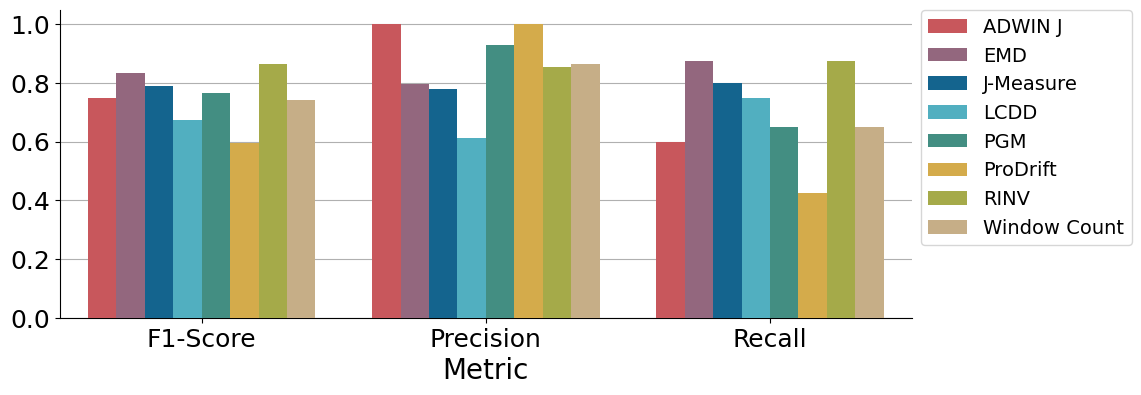

In [19]:

accuracy_plot_df = pd.DataFrame(
    [
        {
            "Algorithm": name,
            "Metric": "F1-Score",
            "Value": computed_accuracy_dicts[name][accuracy_best_param[name]]
        }
        for name in computed_accuracy_dicts.keys()
    ] + [
        {
            "Algorithm": name,
            "Metric": "Precision",
            "Value": computed_precision_dicts[name][accuracy_best_param[name]]
        }
        for name in computed_accuracy_dicts.keys()
    ] + [
        {
            "Algorithm": name,
            "Metric": "Recall",
            "Value": computed_recall_dicts[name][accuracy_best_param[name]]
        }
        for name in computed_accuracy_dicts.keys()
    ]
)

palette=None #{"Precision": "#573deb", "F1-Score": "#ff0076", "Recall": "#ffa600"}
palette = sns.color_palette(colors)
plt.grid(zorder=0)
ax = sns.barplot(x="Metric", y="Value", data=accuracy_plot_df, hue="Algorithm", palette=palette, hue_order=ALPHA_SORT_NAMES,zorder =5)

ax.figure.set_size_inches(11, 4)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.tick_params(labelsize=18)
ax.set_xlabel(ax.get_xlabel(), size = 20)
ax.set_ylabel("", size = 20)
#ax.get_yaxis().set_visible(False)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0,prop={'size': 14})

if not os.path.exists(f"{OUT_PATH}/Accuracy{LAG_WINDOW}"):
    os.makedirs(f"{OUT_PATH}/Accuracy{LAG_WINDOW}")
plt.savefig(f"{OUT_PATH}/Accuracy{LAG_WINDOW}/accuracy_c.pdf", bbox_inches="tight", format="pdf")
plt.show()

### Plot as Points

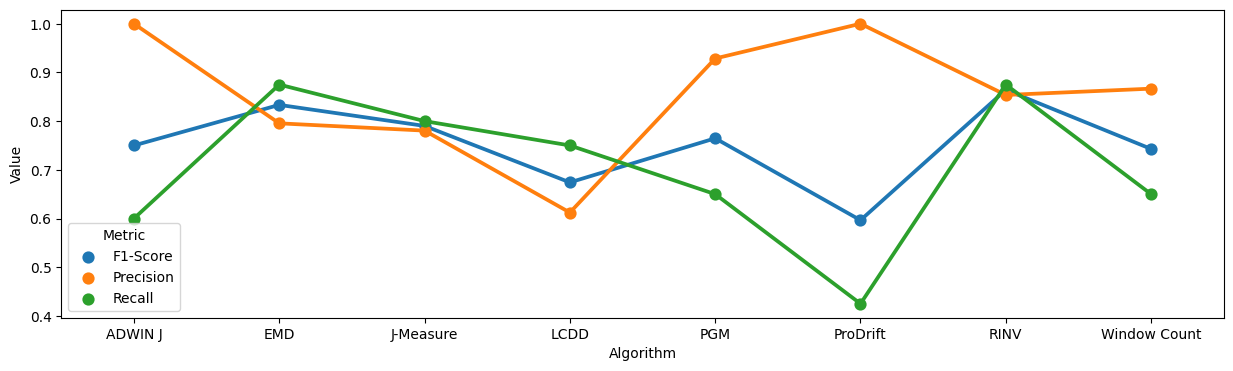

In [20]:
ax = sns.pointplot(
    x="Algorithm",
    y="Value",
    data=accuracy_plot_df,
    hue="Metric",
    order=ALPHA_SORT_NAMES,
    join=True,
)
ax.figure.set_size_inches(15, 4)
plt.show()

## Latency
- Using best parameter setting
- Same logs as above

In [21]:
from statistics import mean

def calcLatencies(df, param_names, lag_window):
    latencies = dict()
    for parameters, group in df.groupby(by=param_names):
        lags = []
        for index, row in group.iterrows():
            actual_cp = row["Actual Changepoints for Log"]
            detected_cp = row["Detected Changepoints"]
            assignments = evaluation.assign_changepoints(detected_cp, actual_cp, lag_window)
            for d, a in assignments:
                lags.append(abs(d-a))
        latencies[parameters] = lags
    return latencies

def calculate_latency(dataframe, lag_window, min_support=1, verbose=True):
    latencies = dict() # Dict holding the best achieved latency per approach
    scaled_latency_dicts = dict() # Dict holding the scaled mean latency per approach per parameter setting
    computed_latency_dicts = dict() # Dict holding the raw list of detection lags per approach per parameter setting
    best_params_latency = dict() # Dict holding the best parameter setting per approach (the one that achieves the best latency)
    for name, a_df in dataframe.groupby(by="Algorithm"):
        result = calcLatencies(a_df, used_parameters[name], lag_window)
        computed_latency_dicts[name] = result
        latency_scaled_dict = {
            param: 1-(mean(result[param])/lag_window) if len(result[param]) >= min_support else np.NaN
            for param in result.keys()
        }
        scaled_latency_dicts[name] = latency_scaled_dict
        best_param = max(latency_scaled_dict,  key=lambda x: latency_scaled_dict[x] if not np.isnan(latency_scaled_dict[x]) else -1)

        best_params_latency[name] = best_param
        latencies[name] = latency_scaled_dict[best_param]

        if verbose:
            print(f"{name}: {(1-latencies[name])*lag_window} Traces; Score: {latencies[name]}")
    return (latencies, scaled_latency_dicts, computed_latency_dicts, best_params_latency)

latencies, scaled_latency_dicts, computed_latency_dicts, best_params_latency = calculate_latency(df_noiseless, LAG_WINDOW, min_support=MIN_SUPPORT, verbose=False)

pd.DataFrame([{'Algorithm': name, 'Lag (Traces)': (1-latencies[name])*LAG_WINDOW, 'Lag (Score)': latencies[name]} for name in latencies.keys()]).sort_values(by="Algorithm", ascending=True)

,Algorithm,Lag (Traces),Lag (Score)
0,ADWIN J,66.720000,0.666400
1,EMD,43.896552,0.780517
2,J-Measure,52.629630,0.736852
3,LCDD,26.000000,0.870000
4,PGM,48.450000,0.757750
5,ProDrift,18.294118,0.908529
6,RINV,54.042318,0.729788
7,Window Count,41.571429,0.792143


#### Plot Latency
- Plotting the observed average latency along with the corresponding standard deviation for the found best parameter setting

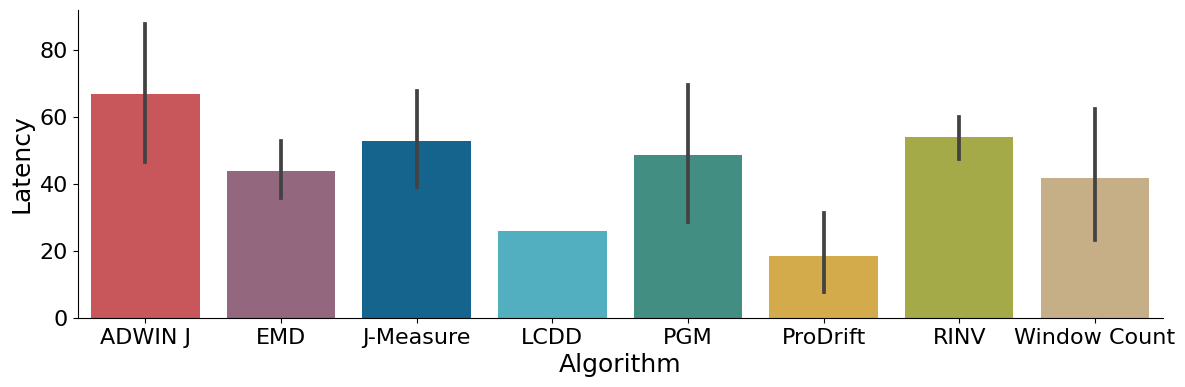

In [22]:
latency_plot_df = pd.DataFrame([
    {
        "Algorithm": name,
        "Unscaled Latency": latency
    }
    for name in computed_latency_dicts.keys()
    for latency in computed_latency_dicts[name][best_params_latency[name]]
])

ax = plt.subplots(figsize=(17, 4))

# Order by latency, ascending (best is left)
# order = [name for name, _ in sorted(latencies.items(), key=lambda x: x[1] if not np.isnan(x[1]) else 0, reverse=True)]
# print(order)
ax = sns.barplot(x="Algorithm", y="Unscaled Latency", data=latency_plot_df,palette= palette, order=ALPHA_SORT_NAMES)
plt.ylabel("Latency")# [Traces]")
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.tick_params(labelsize=16)
ax.set_xlabel(ax.get_xlabel(), size = 18)
ax.set_ylabel(ax.get_ylabel(), size = 18)
ax.figure.set_size_inches(14, 4)

if not os.path.exists(f"{OUT_PATH}/Latency{LAG_WINDOW}"):
    os.makedirs(f"{OUT_PATH}/Latency{LAG_WINDOW}")
plt.savefig(f"{OUT_PATH}/Latency{LAG_WINDOW}/latency.pdf", bbox_inches="tight", format="pdf")
plt.show()


## Versatility

#### Preprocessing

In [23]:
# Only use Ceravolo and Ostovar Logs because these are the only ones that have different change patterns.
# (Theoretically we could also drop all rows containing a nan in the change pattern column? This would be more general)
df_v = df_noiseless[df_noiseless["Log Source"].isin(["Ceravolo", "Ostovar"])].copy(deep=True)

#### Calculation
- Recall of all logs of the same pattern, "concatenated", i.e., accumulate TP and FP first
- Divide this by the number of change patterns

In [24]:
def calc_versatility(dataframe, lag_window, verbose=True):

    versatility_recall_dicts = dict() # Map approach to a dictionary mapping param setting to mean recall over all change patterns
    versatilities = dict() # Map approach to versatility score
    best_params_versatility = dict() # Map approach to best param setting

    for name, group in dataframe.groupby(by="Algorithm"):
        recalls_of_this_approach = dict()
        for params, params_group in group.groupby(by=used_parameters[name]):
            recalls = dict()
            for change_pattern, cp_group in params_group.groupby(by="Change Pattern"):
                TPS = 0
                POSITIVES = 0
                # TP / TP+FN = TP / POSTIVES = Recall
                for index, row in cp_group.iterrows():
                    detected_changepoints = row["Detected Changepoints"]
                    actual_changepoints = row["Actual Changepoints for Log"]

                    tp, _ = evaluation.getTP_FP(detected_changepoints, actual_changepoints, lag_window)

                    TPS += tp
                    POSITIVES += len(actual_changepoints)

                # Recall of this algorithm for this change pattern:
                recall = TPS / POSITIVES if POSITIVES != 0 else np.NaN # Only the case if there are no actual changepoints, which should not be the case
                recalls[change_pattern] = recall
            recalls_of_this_approach[params] = recalls
        versatility_recall_dicts[name] = recalls_of_this_approach
        best_param = max(recalls_of_this_approach, key=lambda x: np.nanmean(list(recalls_of_this_approach[x].values()))) # .values() gives us all the recalls for all change patterns on this param setting
        best_params_versatility[name] = best_param
        versatilities[name] = np.nanmean(list(
            recalls_of_this_approach[best_param].values()
        ))
        
        if verbose:
            print(f"{name}: {versatilities[name]}")
        
    return versatilities, versatility_recall_dicts, best_params_versatility

versatilities, versatility_recall_dicts, best_params_versatility = calc_versatility(df_v, LAG_WINDOW, verbose=False)

pd.DataFrame([{'Algorithm': name, 'Versatility': versatilities[name]} for name in versatilities.keys()]).sort_values(by="Algorithm", ascending=True)


,Algorithm,Versatility
0,ADWIN J,0.593750
1,EMD,0.875000
2,J-Measure,0.770833
3,LCDD,0.708333
4,PGM,0.656250
5,ProDrift,0.385417
6,RINV,0.854167
7,Window Count,0.625000


#### Plot
- Barplot with "bar" for each change pattern and approach

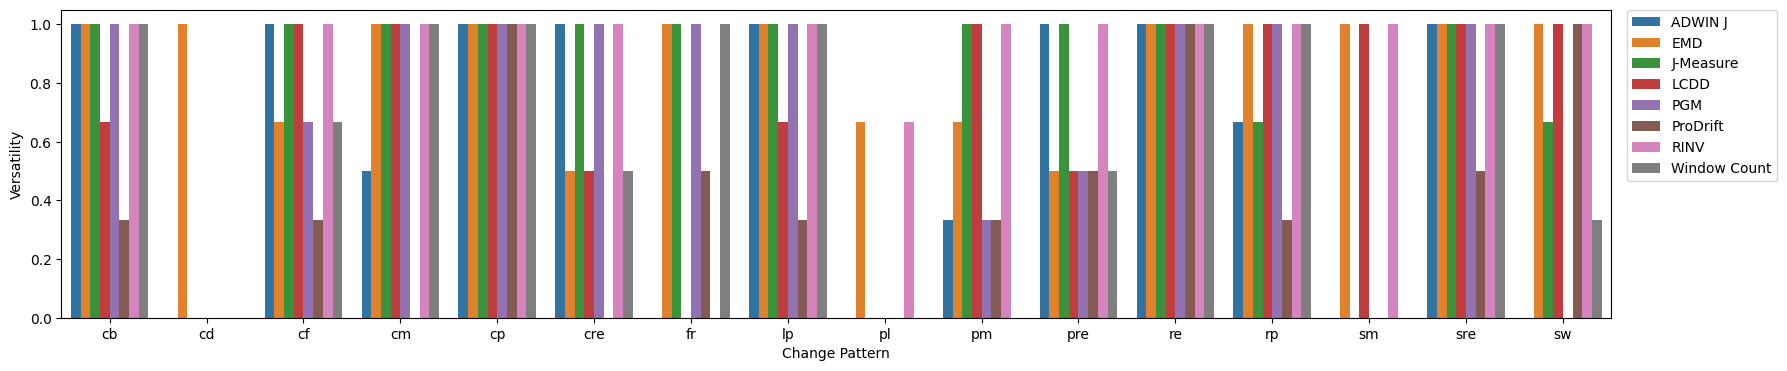

In [25]:
df_vers_plot = pd.DataFrame([
    {
        "Algorithm": name,
        "Change Pattern": cp,
        "Versatility": versatility_recall_dicts[name][best_params_versatility[name]][cp]
    }
    for name in versatility_recall_dicts.keys()
    for cp in versatility_recall_dicts[name][best_params_versatility[name]].keys()
])


fig,ax = plt.subplots(figsize=(20, 4))
sns.barplot(x="Change Pattern", y="Versatility", data=df_vers_plot, hue="Algorithm", ax=ax, hue_order=ALPHA_SORT_NAMES)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)

if not os.path.exists(f"{OUT_PATH}/Versatility{LAG_WINDOW}"):
    os.makedirs(f"{OUT_PATH}/Versatility{LAG_WINDOW}")
plt.savefig(f"{OUT_PATH}/Versatility{LAG_WINDOW}/versatility.pdf", bbox_inches="tight", format="pdf")
plt.show()

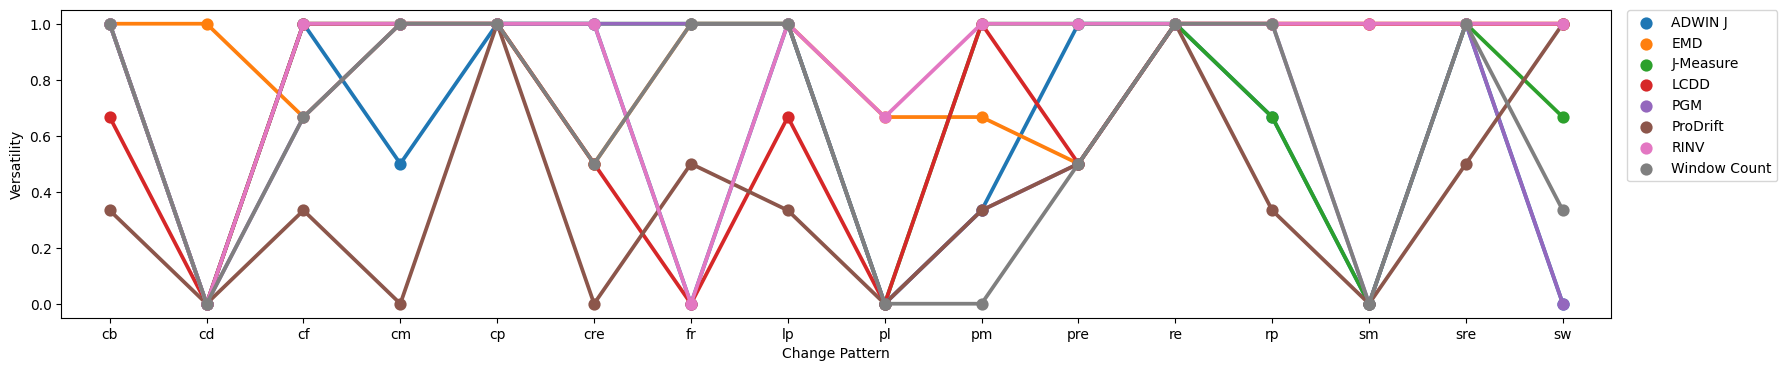

In [26]:
change_patterns = sorted(list(df_vers_plot["Change Pattern"].unique()))
ax = sns.pointplot(
    x="Change Pattern",
    y="Versatility",
    data=df_vers_plot,
    hue="Algorithm",
    hue_order=ALPHA_SORT_NAMES,
    order=change_patterns
)
ax.figure.set_size_inches(20,4)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.show()

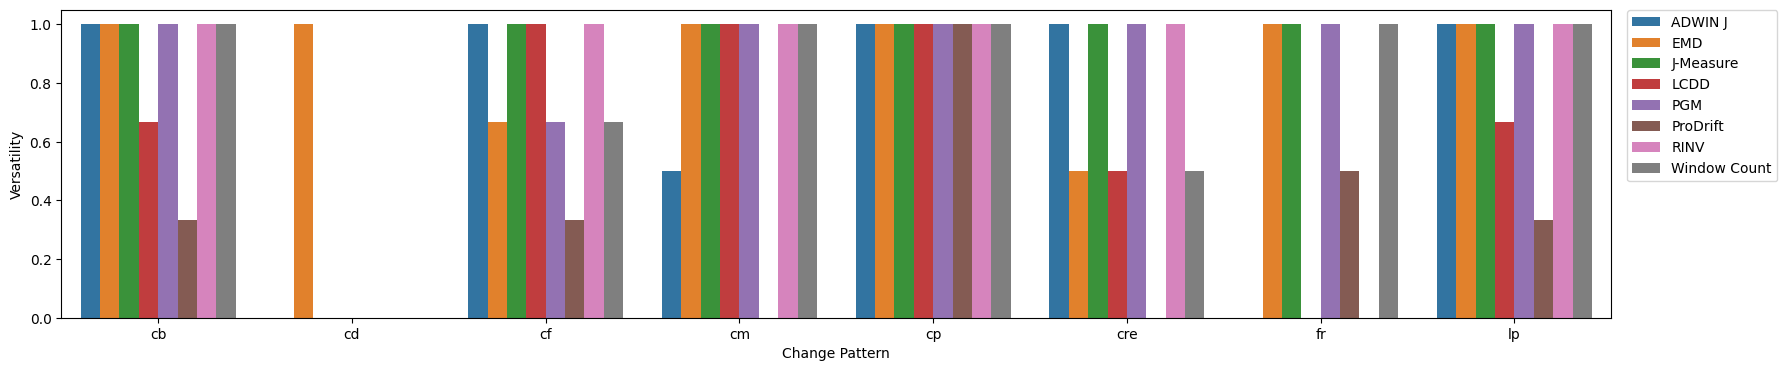

In [27]:
# Plot again, but split in half
first_half = change_patterns[:len(change_patterns)//2]
second_half = change_patterns[len(change_patterns)//2:]
fig,ax = plt.subplots(figsize=(20, 4))
sns.barplot(x="Change Pattern", y="Versatility", data=df_vers_plot[df_vers_plot["Change Pattern"].isin(first_half)], hue="Algorithm", order=first_half, ax=ax, hue_order=ALPHA_SORT_NAMES)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)

plt.savefig(f"{OUT_PATH}/Versatility{LAG_WINDOW}/versatility_split_1.pdf", bbox_inches="tight", format="pdf")
plt.show()

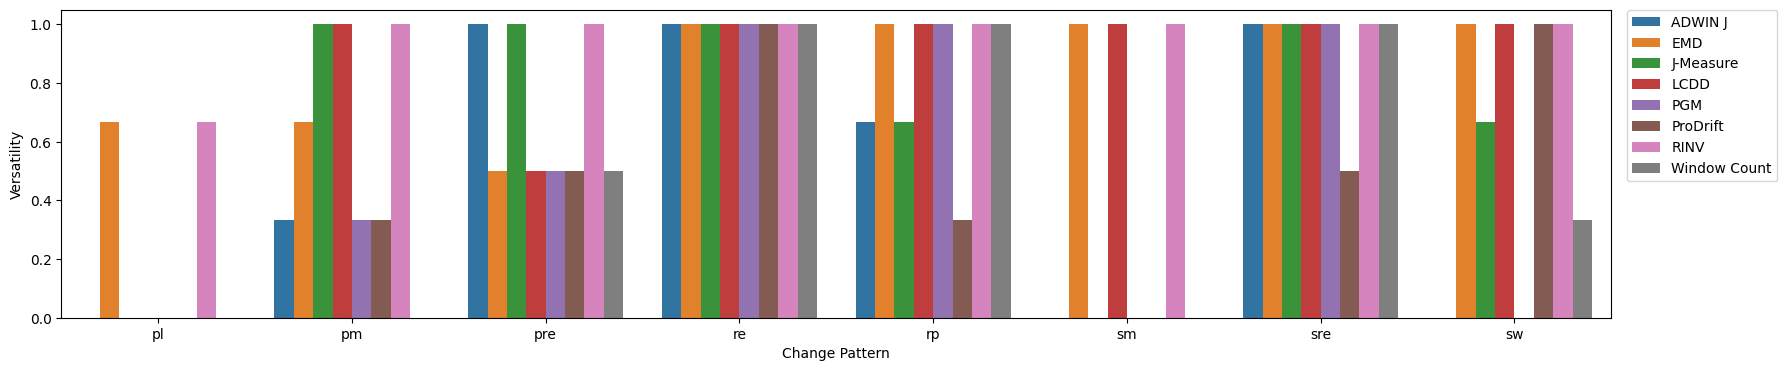

In [28]:
fig2,ax2 = plt.subplots(figsize=(20, 4))
sns.barplot(x="Change Pattern", y="Versatility", data=df_vers_plot[df_vers_plot["Change Pattern"].isin(second_half)], hue="Algorithm", order=second_half, ax=ax2, hue_order=ALPHA_SORT_NAMES)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.savefig(f"{OUT_PATH}/Versatility{LAG_WINDOW}/versatility_split_2.pdf", bbox_inches="tight", format="pdf")
plt.show()

#### Plot as Radar Chart (using plotly)

In [29]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


plotly_default_colors = colors#px.colors.qualitative.Plotly

fill_colors = {
    name: plotly_default_colors[idx]
    for idx,name in enumerate(df_vers_plot["Algorithm"].unique())
}

# ALL RADAR CHARTS IN ONE PLOT, I DONT LIKE THE LAYOUT THOUGH :/
# fig = make_subplots(rows=2, cols=4, specs=[[{'type': 'polar'}]*4]*2, subplot_titles=df_vers_plot["Algorithm"].unique())#, start_cell="bottom-left")
# for idx, (alg, dataframe) in enumerate(df_vers_plot.groupby(by="Algorithm")):
#     sub_df = df_vers_plot[df_vers_plot["Algorithm"] == alg]
#     fig.add_trace(go.Scatterpolar(
#         name = alg,
#         r=sub_df['Versatility'].values,
#         theta=sub_df['Change Pattern'].values,
#         fillcolor=fill_colors[alg],
#         line={'color': fill_colors[alg]}
#     ), row=idx//4+1, col=idx%4+1 )
# fig.update_traces(fill='toself')

# ALL APPROACHES IN THE SAME RADAR CHART - NOT SO READABLE
# fig = go.Figure()
# for alg, dataframe in df_vers_plot.groupby(by="Algorithm"):
#     fig.add_trace(go.Scatterpolar(
#       r = dataframe["Versatility"],
#       theta = dataframe["Change Pattern"],
#       fill = 'toself',
#       name = alg
# ))

# 1 RADAR CHART PER APPROACH - SEPERATE PLOTS - This is my favorite; Can make a nice layout in latex

import warnings
# Futurewarnings will be risen by pandas within plotly, but this is plotly's fault, not ours
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    for alg, dataframe in df_vers_plot.groupby(by="Algorithm"):
        fig = px.line_polar(
            df_vers_plot[df_vers_plot["Algorithm"] == alg],
            r='Versatility',
            theta='Change Pattern',
            line_close=True,
            color='Algorithm',
            color_discrete_map=fill_colors,
            title=None# alg, # Set this to alg if we want the title, I was planning on setting the title in latex
        )
        fig.update_layout(showlegend=False, title_x=0.5, font=dict(size=18)) # Disable legend (as we have only one algorithm per plot) and center title (if present)
        fig.update_traces(fill='toself')

        if not os.path.exists(f"{OUT_PATH}/Versatility{LAG_WINDOW}/Radar_Charts"):
            os.makedirs(f"{OUT_PATH}/Versatility{LAG_WINDOW}/Radar_Charts")
        fig.write_image(f"{OUT_PATH}/Versatility{LAG_WINDOW}/Radar_Charts/radar_chart_{alg.replace(' ','_')}.pdf", format="pdf")
        print(alg)
        fig.show()


ADWIN J


EMD


J-Measure


LCDD


PGM


ProDrift


RINV


Window Count


## Scalability
- Mean Duration
- Across ***all*** logs this time!

In [30]:
scalabilities = dict()
for name, a_df in df.groupby("Algorithm"):
    result = a_df["Duration (Seconds)"].mean()
    result_str = datetime.strftime(datetime.utcfromtimestamp(result), '%H:%M:%S')
    scalabilities[name] = {"avg_seconds": result, "str": result_str}

pd.DataFrame([{'Algorithm': name, 'Scalability': scalabilities[name]["str"], 'Average Seconds': scalabilities[name]['avg_seconds']} for name in scalabilities.keys()]).sort_values(by="Algorithm", ascending=True)

,Algorithm,Scalability,Average Seconds
0,ADWIN J,00:03:41,221.578935
1,EMD,00:13:05,785.938889
2,J-Measure,00:09:14,554.985185
3,LCDD,00:00:00,0.123212
4,PGM,00:00:24,24.934549
5,ProDrift,00:03:31,211.303704
6,RINV,00:00:02,2.916667
7,Window Count,00:09:13,553.920370


#### Plot Boxplot of Mean Absolute Duration

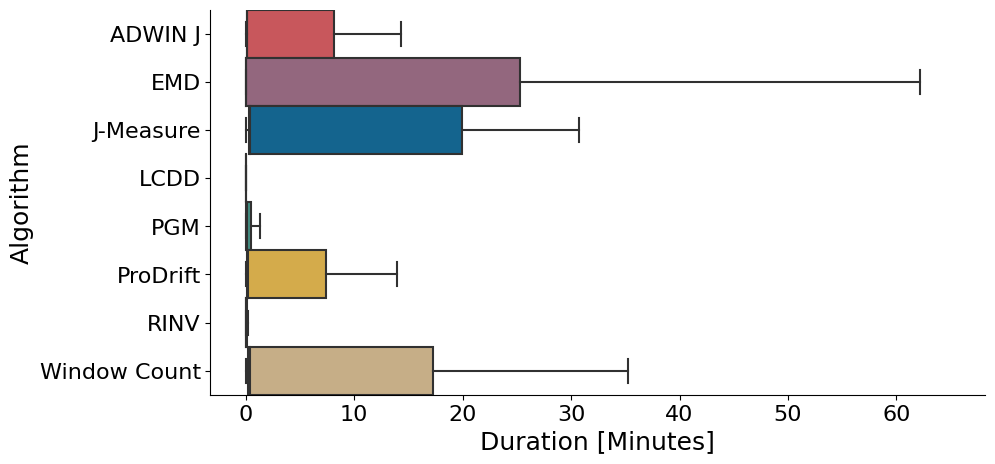

In [31]:
scalability_plot_df = pd.DataFrame([
    {
        "Algorithm": name,
        "Duration": duration / 60
    }
    for name, a_df in dfs
    for duration in a_df["Duration (Seconds)"].tolist()
])

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlabel("Duration [Minutes]")

sorted_names = list(scalabilities.items())
sorted_names.sort(key=lambda x: x[1]["avg_seconds"])

ax = sns.boxplot(
    data=scalability_plot_df,
    order=ALPHA_SORT_NAMES,#[name for name, _ in sorted_names] if False else None, # Disable sorting for now, maybe this means that the order is the same in every plot
    x="Duration",
    y="Algorithm",
    palette = palette,
    width=1,
    ax=ax,
    fliersize=0
)
#ax.figure.set_size_inches(14, 4)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.tick_params(labelsize=16)
ax.set_xlabel(ax.get_xlabel(), size = 18)
ax.set_ylabel(ax.get_ylabel(), size = 18)
plt.xlabel("Duration [Minutes]")

if not os.path.exists(f"{OUT_PATH}/Scalability{LAG_WINDOW}"):
    os.makedirs(f"{OUT_PATH}/Scalability{LAG_WINDOW}")
plt.savefig(f"{OUT_PATH}/Scalability{LAG_WINDOW}/scalability.pdf", bbox_inches="tight", format="pdf")
plt.show()

#### Plot as Barplot as well

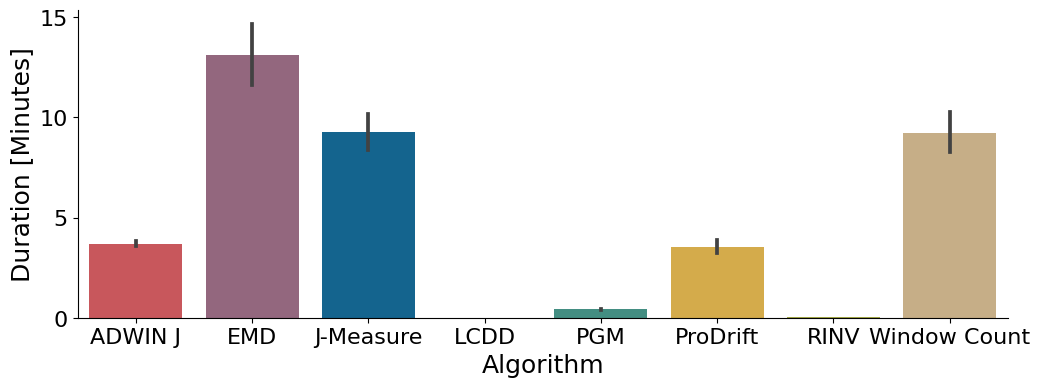

In [32]:
scalability_barplot_df = pd.DataFrame([
    {
        "Algorithm": name,
        "Duration": duration / 60
    }
    for name, a_df in dfs
    for duration in a_df["Duration (Seconds)"].tolist()
])

ax = plt.subplots(figsize=(17, 4))

# Order by latency, ascending (best is left)
# order = [name for name, _ in sorted(latencies.items(), key=lambda x: x[1] if not np.isnan(x[1]) else 0, reverse=True)]
# print(order)

ax = sns.barplot(x="Algorithm", y="Duration", data=scalability_barplot_df,palette = palette, order=ALPHA_SORT_NAMES)
ax.figure.set_size_inches(12, 4)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.tick_params(labelsize=16)
ax.set_xlabel(ax.get_xlabel(), size = 18)
ax.set_ylabel(ax.get_ylabel(), size = 18)
plt.ylabel("Duration [Minutes]")
plt.savefig(f"{OUT_PATH}/Scalability{LAG_WINDOW}/scalability_barplot.pdf", bbox_inches="tight", format="pdf")
plt.show()

## Seconds per Case/Event

In [33]:
df_seconds = df.copy()
# Add Log Length Column
df_seconds["Log Length (Cases)"] = df_seconds[["Log Source", "Log"]].apply(axis=1, func=lambda x: loglengths[Path("EvaluationLogs", x[0], x[1]+".xes.gz")])
df_seconds["Log Length (Events)"] = df_seconds[["Log Source", "Log"]].apply(axis=1, func=lambda x: loglengths_events[Path("EvaluationLogs", x[0], x[1]+".xes.gz")])

seconds_per_case = dict()
seconds_per_event = dict()

for name, group in df_seconds.groupby("Algorithm"):
    total_seconds = group["Duration (Seconds)"].sum()

    total_cases = group["Log Length (Cases)"].sum()
    total_events = group["Log Length (Events)"].sum()

    seconds_per_case[name] = total_seconds / total_cases
    seconds_per_event[name] = total_seconds / total_events

pd.DataFrame([{'Algorithm': name, 'Seconds per Case': seconds_per_case[name], 'Seconds per Event': seconds_per_event[name]} for name in seconds_per_case.keys()]).sort_values(by="Algorithm", ascending=True)

,Algorithm,Seconds per Case,Seconds per Event
0,ADWIN J,0.115298,0.004423
1,EMD,0.408962,0.015688
2,J-Measure,0.288786,0.011078
3,LCDD,0.000064,0.000002
4,PGM,0.012975,0.000498
5,ProDrift,0.109952,0.004218
6,RINV,0.001518,0.000058
7,Window Count,0.288232,0.011056


In [34]:
df_seconds["Milliseconds per Event"] = df_seconds.apply(lambda x: (x["Duration (Seconds)"]*1000) / x["Log Length (Events)"], axis=1)
df_seconds[["Duration (Seconds)", "Log Length (Events)", "Milliseconds per Event"]].head()

,Duration (Seconds),Log Length (Events),Milliseconds per Event
0,4.0,73854,0.054161
1,4.0,73854,0.054161
2,4.0,73854,0.054161
3,4.0,73854,0.054161
4,4.0,73854,0.054161


### Plot Boxplot and Barplot of milliseconds per event

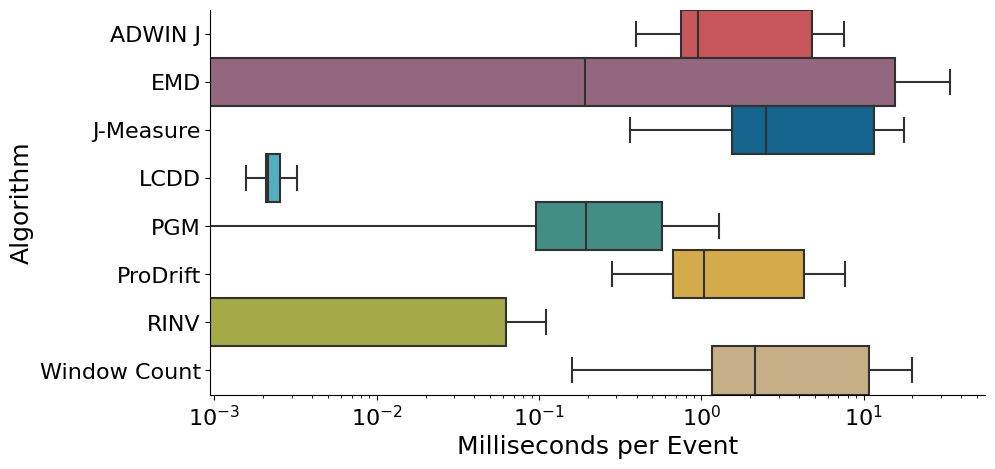

In [35]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlabel("Milliseconds per Event")


ax = sns.boxplot(
    data=df_seconds,
    order=ALPHA_SORT_NAMES,
    x="Milliseconds per Event",
    y="Algorithm",
    palette = palette,
    width=1,
    ax=ax,
    fliersize=0

)

ax.set_xscale("log")

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.tick_params(labelsize=16)
ax.set_xlabel(ax.get_xlabel(), size = 18)
ax.set_ylabel(ax.get_ylabel(), size = 18)
plt.xlabel("Milliseconds per Event")

if not os.path.exists(f"{OUT_PATH}/Scalability{LAG_WINDOW}"):
    os.makedirs(f"{OUT_PATH}/Scalability{LAG_WINDOW}")
plt.savefig(f"{OUT_PATH}/Scalability{LAG_WINDOW}/scalability_mseconds_per_event.pdf", bbox_inches="tight", format="pdf")
plt.show()

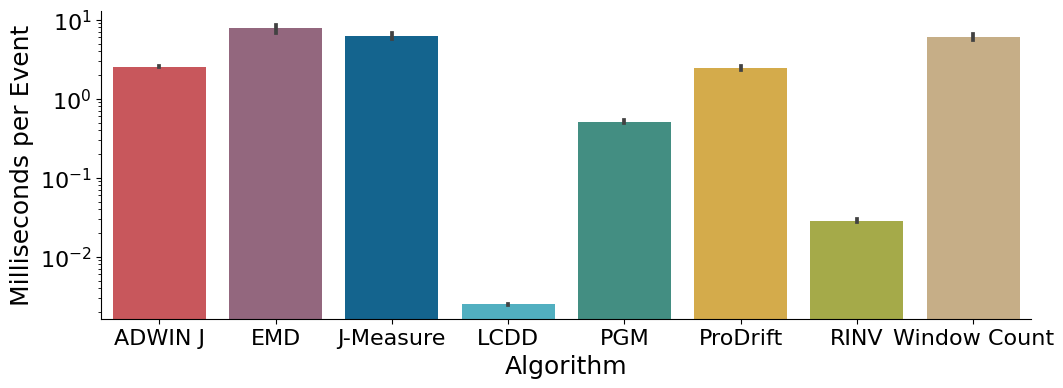

In [36]:
ax = plt.subplots(figsize=(17, 4))

ax = sns.barplot(x="Algorithm", y="Milliseconds per Event", data=df_seconds, palette = palette, order=ALPHA_SORT_NAMES)
ax.figure.set_size_inches(12, 4)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.tick_params(labelsize=16)
ax.set_xlabel(ax.get_xlabel(), size = 18)
ax.set_ylabel(ax.get_ylabel(), size = 18)
ax.set_yscale("log")
plt.ylabel("Milliseconds per Event")

if not os.path.exists(f"{OUT_PATH}/Scalability{LAG_WINDOW}"):
    os.makedirs(f"{OUT_PATH}/Scalability{LAG_WINDOW}")
plt.savefig(f"{OUT_PATH}/Scalability{LAG_WINDOW}/scalability_mseconds_per_event_barplot.pdf", bbox_inches="tight", format="pdf")
plt.show()

## Parameter Sensitivity
- For each Parameter setting, harmonic mean of *accuracy*, *latency*, and *versatility*
  - &rarr; Visualize the variance, etc., with a boxplot
- Only noiseless logs again

In [37]:
versatility_score_per_param = {
    name: {
        params: np.nanmean(list(versatility_recall_dicts[name][params].values()))
        for params in versatility_recall_dicts[name].keys()
    }
    for name in versatility_recall_dicts.keys()
}


sensitivities = dict()
for name in df["Algorithm"].unique():
    _sensitivities = dict()
    acc = computed_accuracy_dicts[name]
    lat = scaled_latency_dicts[name]
    vers = versatility_score_per_param[name]
    for param_choice in acc.keys():
        sensitivity = harmonic_mean([acc[param_choice], vers[param_choice], lat[param_choice]])
        _sensitivities[param_choice] = sensitivity
    sensitivities[name] = _sensitivities


c:\Users\Cam\anaconda3\envs\cdrift-evaluation\lib\statistics.py:428: RuntimeWarning:

divide by zero encountered in double_scalars



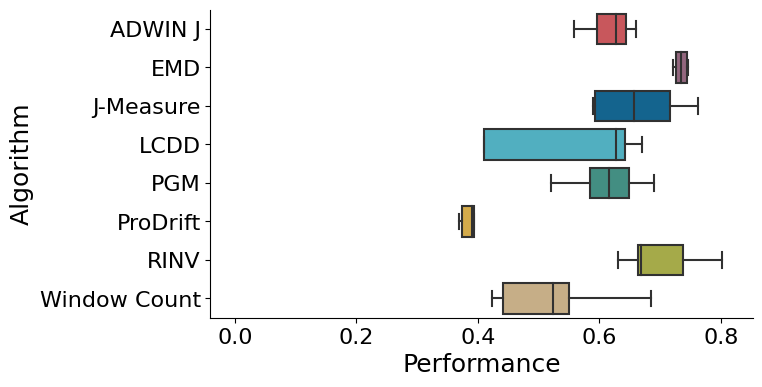

In [38]:
sens_df = pd.DataFrame([
    {
        "Parameters": param,
        "Algorithm": name,
        "Sensitivity Score": sens
    }
    for name, sens_dict in sensitivities.items()
    for param, sens in sens_dict.items()
])
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.boxplot(
    data=sens_df,
    x="Sensitivity Score",
    y="Algorithm",
    palette = palette,
    ax=ax,
    fliersize=0,
    order=ALPHA_SORT_NAMES
)
ax.figure.set_size_inches(7, 4)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.tick_params(labelsize=16)
ax.set_xlabel("Performance", size = 18)
ax.set_ylabel(ax.get_ylabel(), size = 18)

if not os.path.exists(f"{OUT_PATH}/Parameter_Sensitivity{LAG_WINDOW}"):
    os.makedirs(f"{OUT_PATH}/Parameter_Sensitivity{LAG_WINDOW}")
plt.savefig(f"{OUT_PATH}/Parameter_Sensitivity{LAG_WINDOW}/param_sensitivity.pdf", bbox_inches="tight", format="pdf")
plt.show()

In [39]:
# Inter Quartile Range
sensitivity_iqrs = dict()
for name, sens in sensitivities.items():
    _iqr = iqr(list(sens.values()), nan_policy="omit")
    sensitivity_iqrs[name] = _iqr

pd.DataFrame([{'Algorithm': name, 'Inner-Quartile Range': sensitivity_iqrs[name]} for name in sensitivity_iqrs.keys()]).sort_values(by="Algorithm", ascending=True)

,Algorithm,Inner-Quartile Range
6,ADWIN J,0.048221
4,EMD,0.017050
2,J-Measure,0.123339
7,LCDD,0.231666
5,PGM,0.063480
1,ProDrift,0.019829
0,RINV,0.074717
3,Window Count,0.109204


## Robustness

### Preprocessing

In [40]:
# # Only use the Ceravolo and Ostovar Logs as Bose has only 1 log, i.e., no noise levels
df_robust = df[df["Log Source"].isin(["Ceravolo", "Ostovar"])].copy(deep=True)
df_robust[['Algorithm', 'Log Source', 'Log', 'Change Pattern', 'Noise Level']]

,Algorithm,Log Source,Log,Change Pattern,Noise Level
0,RINV,Ostovar,Atomic_Frequency_output_Frequency_5,fr,5
1,RINV,Ostovar,Atomic_Frequency_output_Frequency_5,fr,5
2,RINV,Ostovar,Atomic_Frequency_output_Frequency_5,fr,5
3,RINV,Ostovar,Atomic_Frequency_output_Frequency_5,fr,5
4,RINV,Ostovar,Atomic_Frequency_output_Frequency_5,fr,5
...,...,...,...,...,...
39704,LCDD,Ostovar,Atomic_ParallelMove_output_ParallelMove_2,pm,2
39705,LCDD,Ostovar,Atomic_SerialMove_output_SerialMove_5,sm,5
39708,LCDD,Ceravolo,sudden_trace_noise15_1000_sw,sw,15
39709,LCDD,Ceravolo,sudden_trace_noise0_1000_cp,cp,0


### Calculate Harmonic Means

In [41]:
def calc_robustnesses(dataframe, lag_window):
    robustnesses = dict()

    for noise_level, noise_df in dataframe.groupby("Noise Level"):
        # Calculate accuracy over these logs
        accuracies, _, _, _, _ = calculate_accuracy_metric_df(noise_df, lag_window, verbose=False)
        latencies, _, _, _ = calculate_latency(noise_df, lag_window, min_support=MIN_SUPPORT, verbose=False)
        versatilities, _, _ = calc_versatility(noise_df, lag_window, verbose=False)

        assert accuracies.keys() == latencies.keys() == versatilities.keys()

        robustnesses[noise_level] = {
            approach: harmonic_mean([accuracies[approach], latencies[approach], versatilities[approach]])
            for approach in accuracies.keys()
        }
    return robustnesses

means_ceravolo = calc_robustnesses(df_robust[df_robust["Log Source"] == "Ceravolo"], LAG_WINDOW)
means_ostovar = calc_robustnesses(df_robust[df_robust["Log Source"] == "Ostovar"], LAG_WINDOW)


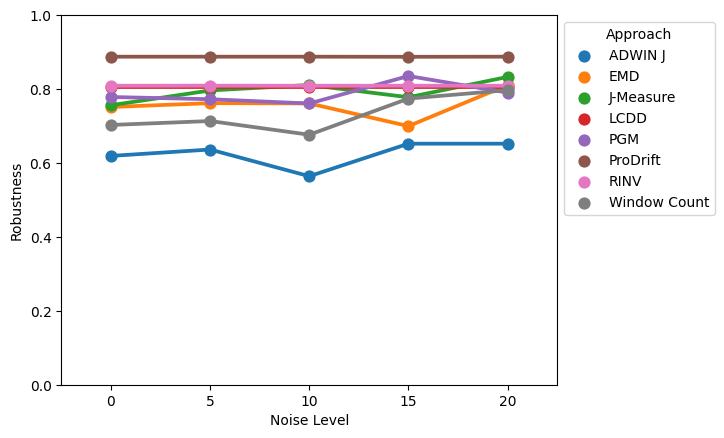

In [42]:
plot_df_robust = pd.DataFrame(
    ([
        {
            "Log Set": "Ostovar",
            "Approach": name,
            "Noise Level": int(noise_level),
            "Robustness": robustness
        }
        for noise_level, robust_dict  in means_ostovar.items()
        for name, robustness in robust_dict.items()
    ] + [
        {
            "Log Set": "Ceravolo",
            "Approach": name,
            "Noise Level": int(noise_level),
            "Robustness": robustness
        }
        for noise_level, robust_dict  in means_ceravolo.items()
        for name, robustness in robust_dict.items()
    ])
)

ax = sns.pointplot(x="Noise Level", y="Robustness", hue="Approach", data=plot_df_robust[plot_df_robust["Log Set"] == "Ceravolo"], errorbar=None)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_ylim(0,1)
plt.show()

### Compute AUC

In [43]:
# Calculate AUC Thing
def convert_harm_mean_to_auc(means, div_zero_default=0):
    ## Conventions:
        # If any harmonic mean is nan, then set it to 0 instead


    def _convert_nan_to_zero(x):
        if np.isnan(x):
            x = 0
        return x

    # means maps {noise_level: {approach: robustness}}
    # reformat to {approach: [(noise_level, robustness)]}
    means = {
        approach: [
            (int(noise_level), _convert_nan_to_zero(means[noise_level][approach]))
            for noise_level in means.keys()
        ]
        for approach in means["0"].keys()
    }

    robustnesses = dict()
    for approach in means.keys():
        points = sorted(means[approach], key=lambda x: x[0])

        # Initial Robustness - Use to model "Ideal Robustness"
        initial_robustness = points[0][1] # Robustness for lowest (0%) noise
        ideal_auc = initial_robustness * (points[-1][0] - points[0][0]) # AUC if it was always exactly as good as for the lowest noise level. If performance increases with higher noise, the achieved AUC might be larger than ideal AUC
        prev_noise, prev_robust = points[0]
        auc = 0
        for noise, robust in points[1:]:
            delta_noise = noise-prev_noise
            sum_robust = prev_robust+robust

            # "ROC Index"
            area = (delta_noise * sum_robust) / 2# Area under curve for this segment
            auc += area

            prev_noise = noise
            prev_robust = robust

        if ideal_auc != 0:
            robustnesses[approach] = auc / ideal_auc
        else:
            robustnesses[approach] = div_zero_default
    return robustnesses

robustness_ceravolo = convert_harm_mean_to_auc(means_ceravolo)
robustness_ostovar = convert_harm_mean_to_auc(means_ostovar)

### Calculate Final Robustness Score by Calculating mean of Ceravolo and Ostovar

In [44]:
assert robustness_ceravolo.keys() == robustness_ostovar.keys() # This should always be the case..
robustnesses = {
    name: (robustness_ceravolo[name] + robustness_ostovar[name]) / 2
    for name in robustness_ceravolo.keys()
}

pd.DataFrame([{'Algorithm': name, 'Robustness': robustnesses[name]} for name in robustnesses.keys()]).sort_values(by="Algorithm", ascending=True)


,Algorithm,Robustness
0,ADWIN J,0.953118
1,EMD,1.002616
2,J-Measure,1.050012
3,LCDD,0.990769
4,PGM,1.046524
5,ProDrift,0.599953
6,RINV,0.600044
7,Window Count,1.028665


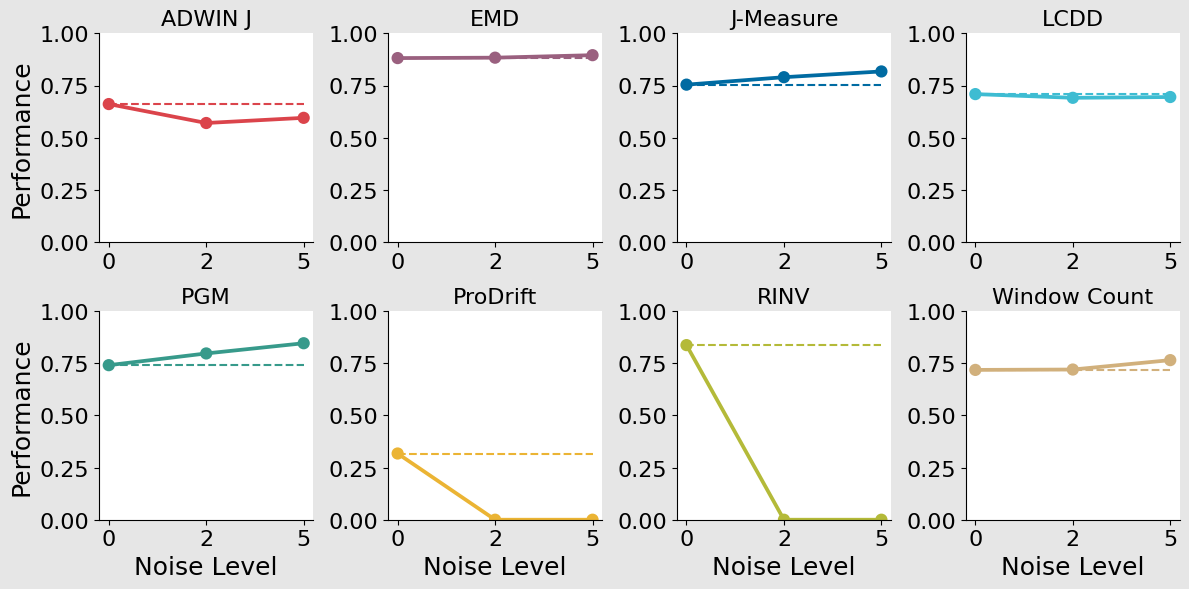

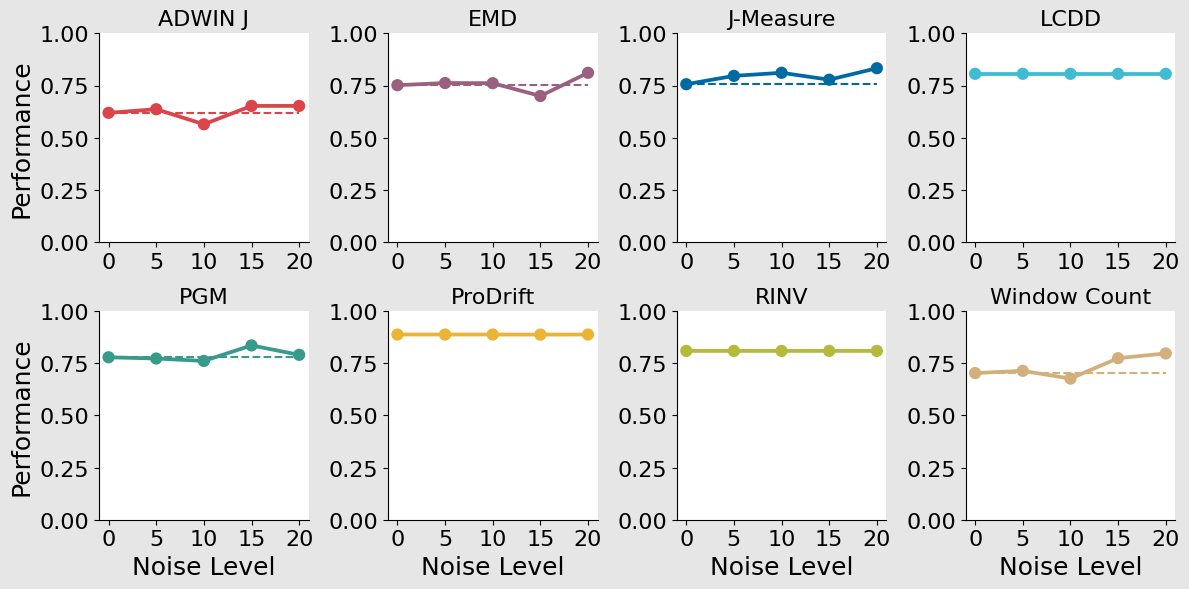

In [45]:
def plot_robustness(robustness_df, logset:str, color_map):
    fig, axs = plt.subplots(2,4, figsize=(12,6))
    #fig.suptitle(f"Robustness of Approaches for {logset} Logs")
    
    for idx, name in enumerate(robustness_df["Approach"].unique()):
        row_offset = idx // 4
        col_offset = idx % 4
        ax = axs[row_offset, col_offset]
        relevant_df = robustness_df[(robustness_df["Approach"] == name) & (robustness_df["Log Set"] == logset)]
        sns.pointplot(x="Noise Level", y="Robustness", data=relevant_df, errorbar=None,color= color_map[name], ax=ax)#, title=name)
        ax.set_ylim(0,1)
        ax.set_title(name, size = 16)
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        ax.tick_params(labelsize=16)
        ax.set_xlabel(ax.get_xlabel() if row_offset == 1 else "", size = 18)
        ax.set_ylabel("Performance" if col_offset == 0 else "", size = 18)
        robustness_of_zero_noise = min(zip(relevant_df["Noise Level"], relevant_df["Robustness"]), key=lambda x: x[0])[1]
        if np.isnan(robustness_of_zero_noise):
            robustness_of_zero_noise = 0
        # plt.axhline(y=robustness_of_zero_noise, color='r', linestyle='-', ax=ax)
        ax.hlines(robustness_of_zero_noise, color=color_map[name], linestyle='dashed', xmin=0, xmax=len(relevant_df["Noise Level"].unique())-1)
        fig.tight_layout()
        #ax.grid()
        fig.set_facecolor('0.9')
    return fig, axs

if not os.path.exists(f"{OUT_PATH}/Robustness{LAG_WINDOW}"):
    os.makedirs(f"{OUT_PATH}/Robustness{LAG_WINDOW}")

fig_ostovar, axs_ostovar = plot_robustness(plot_df_robust, "Ostovar", color_map)
fig_ostovar.savefig(f"{OUT_PATH}/Robustness{LAG_WINDOW}/robustness_ostovar_logs.pdf", bbox_inches="tight", format="pdf")
plt.show(fig_ostovar)

fig_ceravolo, axs_ceravolo = plot_robustness(plot_df_robust, "Ceravolo", color_map)
fig_ceravolo.savefig(f"{OUT_PATH}/Robustness{LAG_WINDOW}/robustness_ceravolo_logs.pdf", bbox_inches="tight", format="pdf")
plt.show(fig_ceravolo)

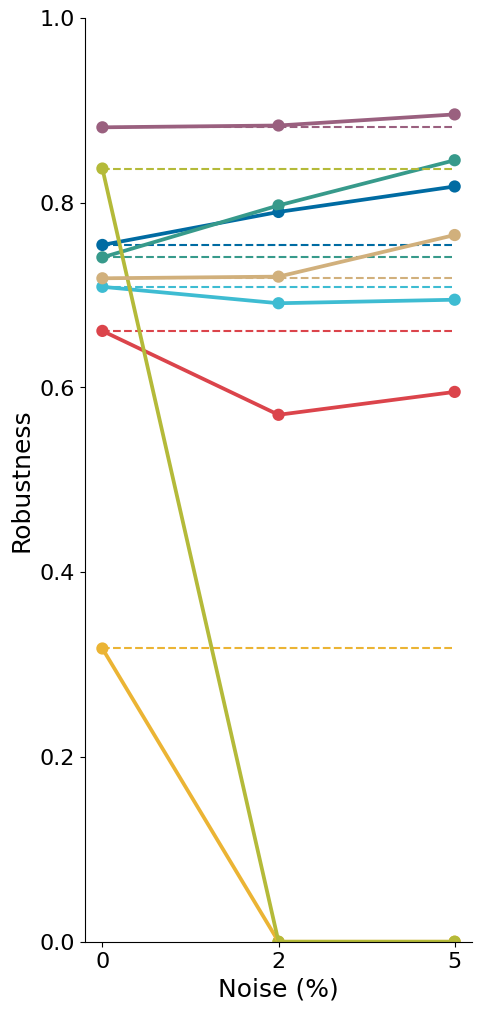

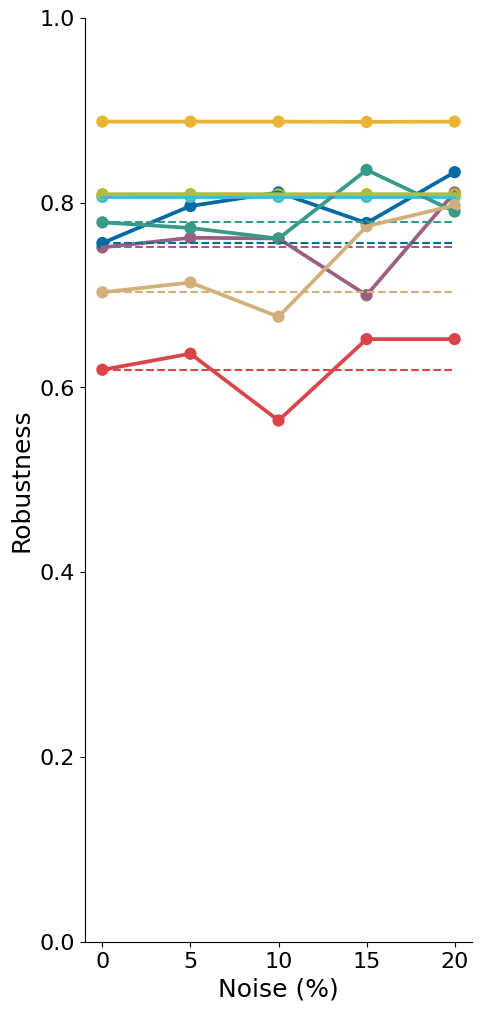

In [46]:
def plot_robustness(robustness_df, logset:str, color_map):
    
    for _, name in enumerate(robustness_df["Approach"].unique()):
        relevant_df = robustness_df[(robustness_df["Approach"] == name) & (robustness_df["Log Set"] == logset)]
        ax = sns.pointplot(x="Noise Level", y="Robustness", data=relevant_df, errorbar=None,color= color_map[name])#, title=name)
        ax.set_ylim(0,1)
        ax.figure.set_size_inches(5, 12)
        #ax.set_title(logset+" Logs with Different Noise Levels", size = 18)
        ax.set_xlabel("Noise (%)")
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        ax.tick_params(labelsize=16)
        ax.set_xlabel(ax.get_xlabel(), size = 18)
        ax.set_ylabel(ax.get_ylabel(), size = 18)
        robustness_of_zero_noise = min(zip(relevant_df["Noise Level"], relevant_df["Robustness"]), key=lambda x: x[0])[1]
        if np.isnan(robustness_of_zero_noise):
            robustness_of_zero_noise = 0
        # plt.axhline(y=robustness_of_zero_noise, color='r', linestyle='-', ax=ax)
        ax.hlines(robustness_of_zero_noise, color=color_map[name], linestyle='dashed', xmin=0, xmax=len(relevant_df["Noise Level"].unique())-1)
    return ax.figure

if not os.path.exists(f"{OUT_PATH}/Robustness{LAG_WINDOW}"):
    os.makedirs(f"{OUT_PATH}/Robustness{LAG_WINDOW}")

fig_ostovar = plot_robustness(plot_df_robust, "Ostovar", color_map)
fig_ostovar.savefig(f"{OUT_PATH}/Robustness{LAG_WINDOW}/robustness_ostovar_logs_all_in_one.pdf", bbox_inches="tight", format="pdf")
plt.show(fig_ostovar)

fig_ceravolo = plot_robustness(plot_df_robust, "Ceravolo", color_map)
fig_ceravolo.savefig(f"{OUT_PATH}/Robustness{LAG_WINDOW}/robustness_ceravolo_logs_all_in_one.pdf", bbox_inches="tight", format="pdf")
plt.show(fig_ceravolo)

## Save Results

In [47]:
results_df = pd.DataFrame([
    {
        "Algorithm": name,
        "Accuracy": accuracies[name],
        "Latency": (1-latencies[name])*LAG_WINDOW,
        "Versatility": versatilities[name],
        "Scalability": scalabilities[name]["str"],
        "Milliseconds per Case": seconds_per_case[name]*1000,
        "Milliseconds per Event": seconds_per_event[name]*1000,
        "Parameter Sensitivity (IQR)": sensitivity_iqrs[name],
        "Robustness": robustnesses[name]
    }
    for name in df["Algorithm"].unique()
])

results_df.to_csv(f"{OUT_PATH}/evaluation_measures{LAG_WINDOW}.csv", index=False)
results_df

,Algorithm,Accuracy,Latency,Versatility,Scalability,Milliseconds per Case,Milliseconds per Event,Parameter Sensitivity (IQR),Robustness
0,RINV,0.864198,54.042318,0.854167,00:00:02,1.517683,0.058217,0.074717,0.600044
1,ProDrift,0.596491,18.294118,0.385417,00:03:31,109.951569,4.217672,0.019829,0.599953
2,J-Measure,0.790123,52.629630,0.770833,00:09:14,288.785719,11.077635,0.123339,1.050012
3,Window Count,0.742857,41.571429,0.625000,00:09:13,288.231644,11.056381,0.109204,1.028665
4,EMD,0.833333,43.896552,0.875000,00:13:05,408.962136,15.687525,0.017050,1.002616
5,PGM,0.764706,48.450000,0.656250,00:00:24,12.974655,0.497699,0.063480,1.046524
6,ADWIN J,0.750000,66.720000,0.593750,00:03:41,115.298271,4.422768,0.048221,0.953118
7,LCDD,0.674157,26.000000,0.708333,00:00:00,0.064113,0.002459,0.231666,0.990769
